# Comment Processing 03

### Comment Type

In parts 01 and 02 we counted comments and found out which comments denote applause by which parties.
The next step is to bring both together and find out whose speaches are applauded by which parties.

---


In [1]:
import pandas as pd
from util.getComments import getComments
from util.countApplause import countApplause
import matplotlib.pyplot as plt
from tueplots import bundles
import numpy as np
from util.colors import sixParties


In [2]:
%store -r dataExtracted
dataExtracted: pd.DataFrame


In [3]:
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})
# Use neurips style
plt.rcParams.update(bundles.neurips2021())


In [4]:
# parties = dataExtracted["main-speaker-party"].unique()
# hard coded list for guaranteed order

parties = ['Alternative für Deutschland', 'Bündnis 90/Die Grünen', 'Christlich Demokratische Union Deutschlands',
           'Christlich-Soziale Union in Bayern', 'Die Linke', 'Freie Demokratische Partei', 'Sozialdemokratische Partei Deutschlands']
commentsPerParty = [getComments(
    dataExtracted, partyFilter=party) for party in parties]


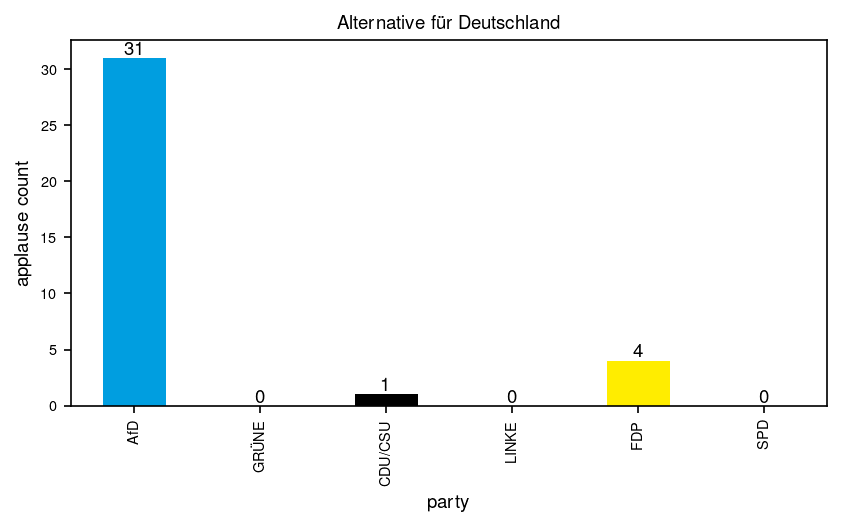

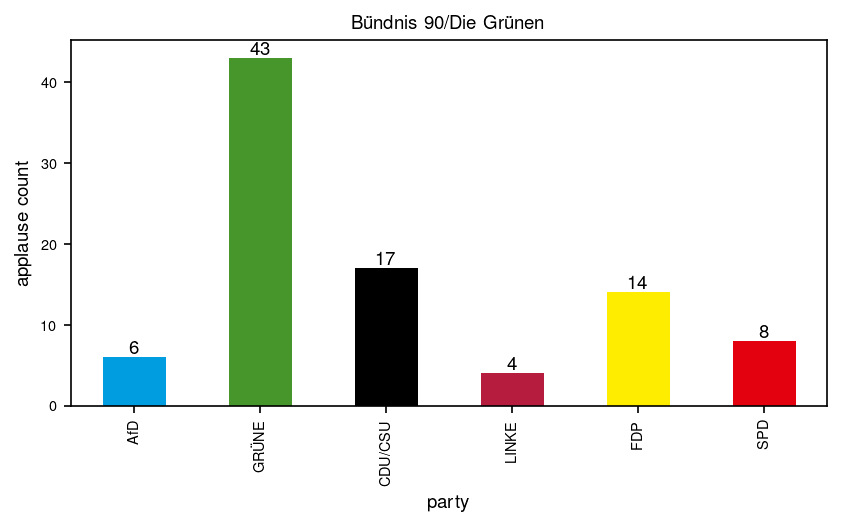

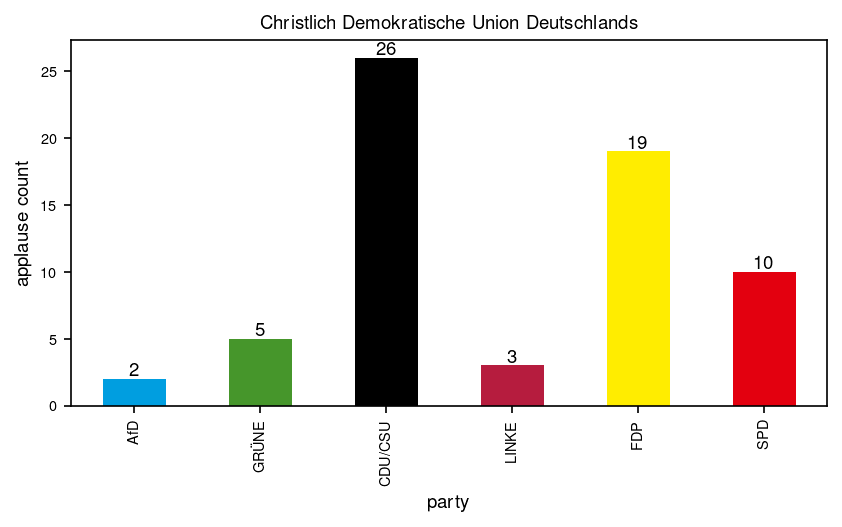

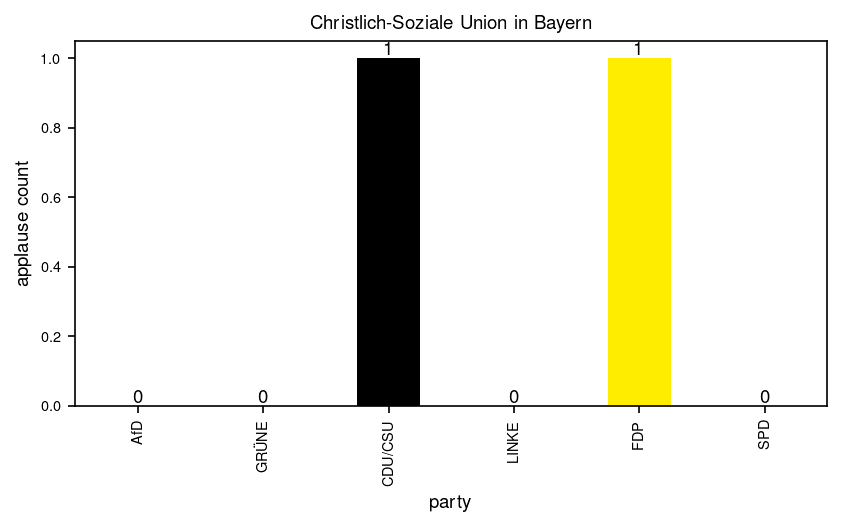

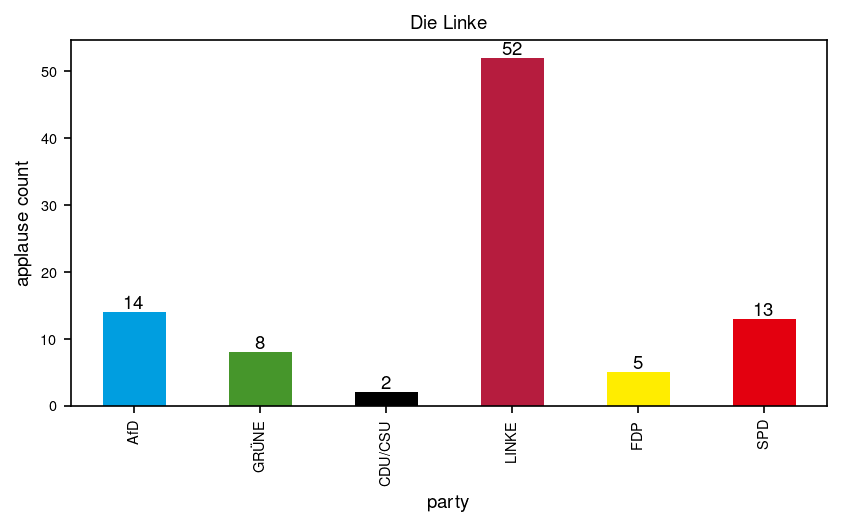

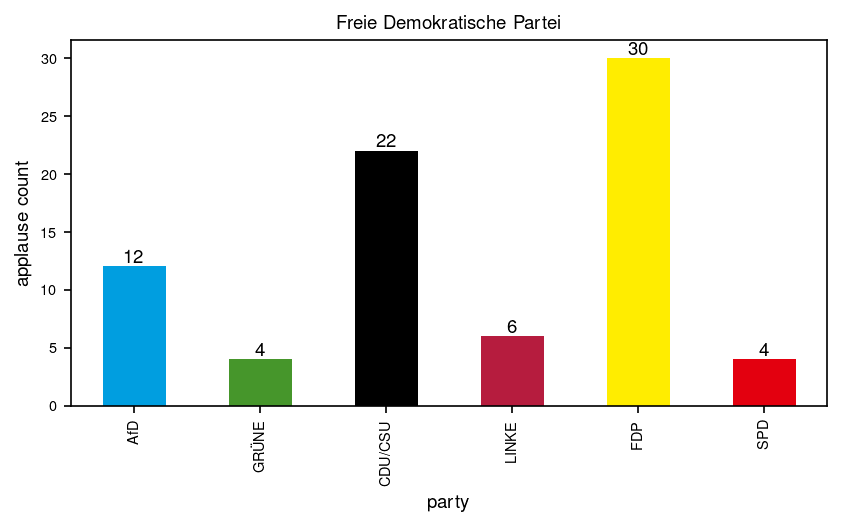

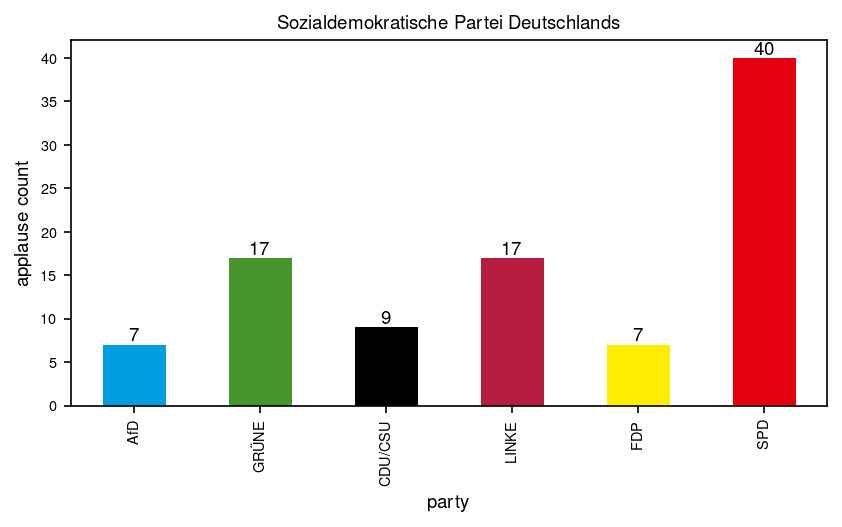

In [5]:
# party - the party speaking
# DF - DF with each party and the amount of applause given to the party speaking
applauseDFs = [(party, countApplause(comments))
               for (party, comments) in zip(parties, commentsPerParty)]

# plot
for (party, applauseDF) in applauseDFs:
    ax = applauseDF.plot.bar(
        x="party", y="applause count", ylabel="applause count", legend=False, title=party, color=sixParties)
    for p in ax.patches:
        ax.annotate(p.get_height(),
                    (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 4), textcoords='offset points')


Now we have one plot for every party. We can read some information out of these but it would make much more sense if these would be normalized. So let's make them!


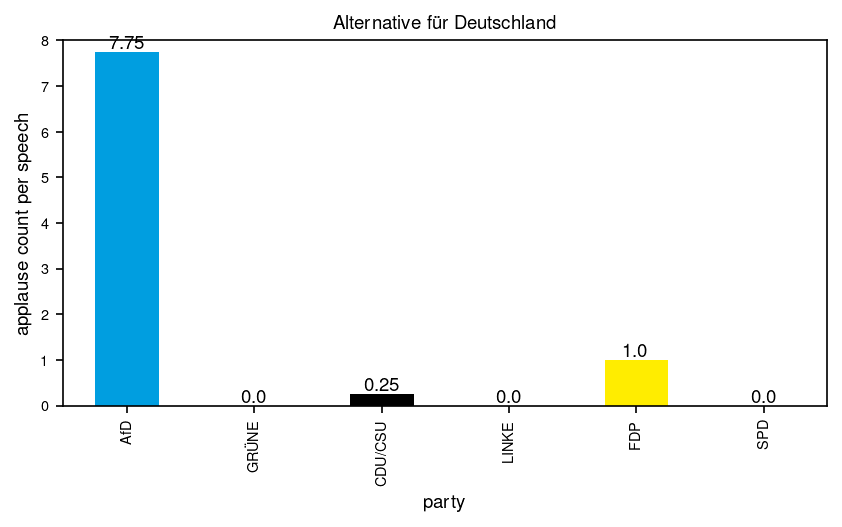

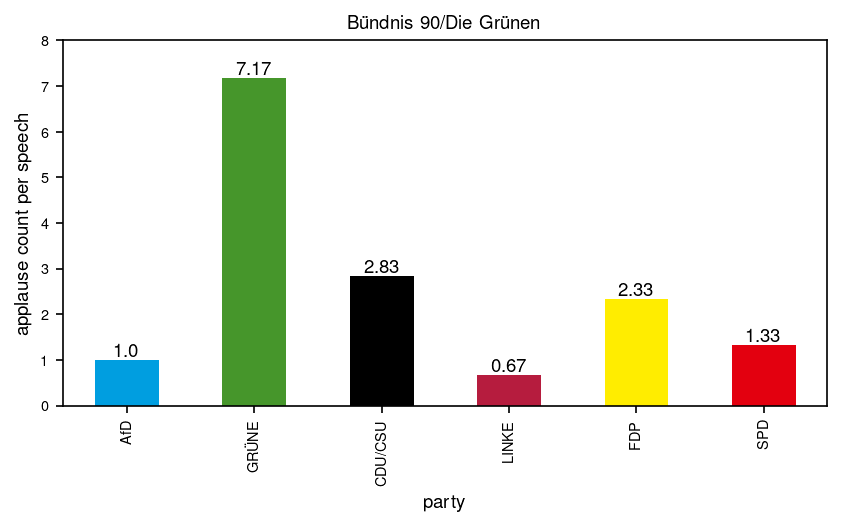

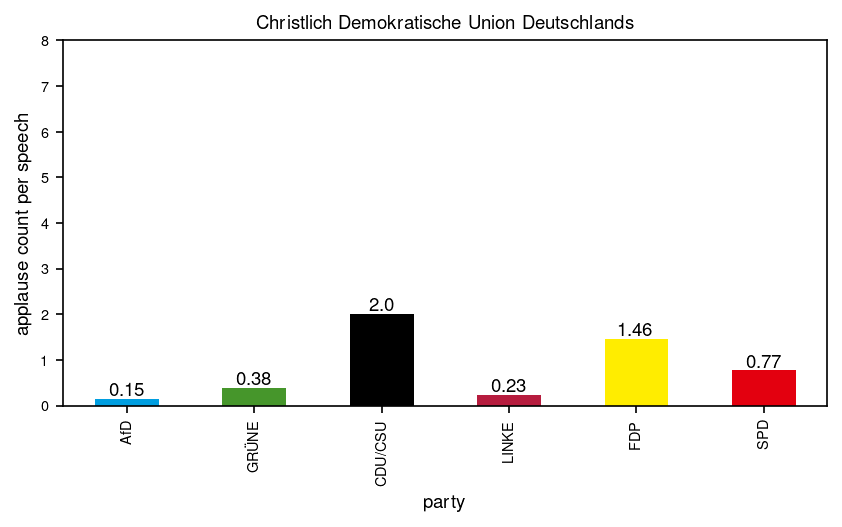

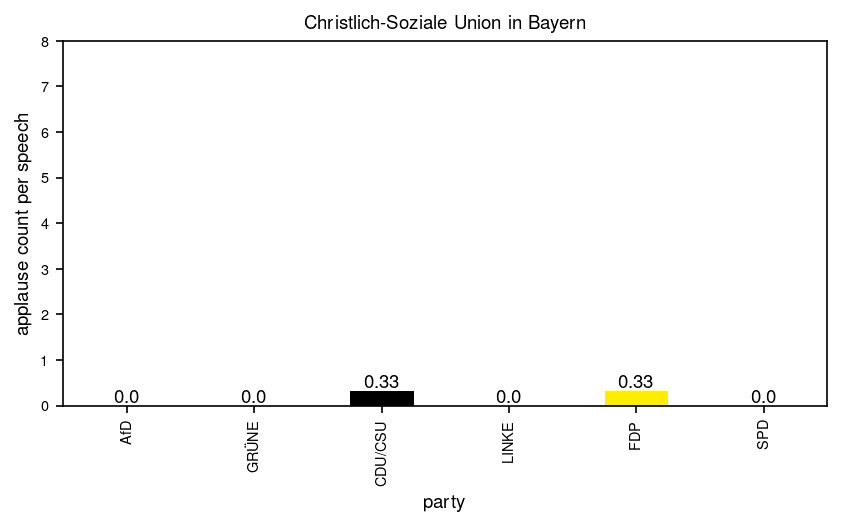

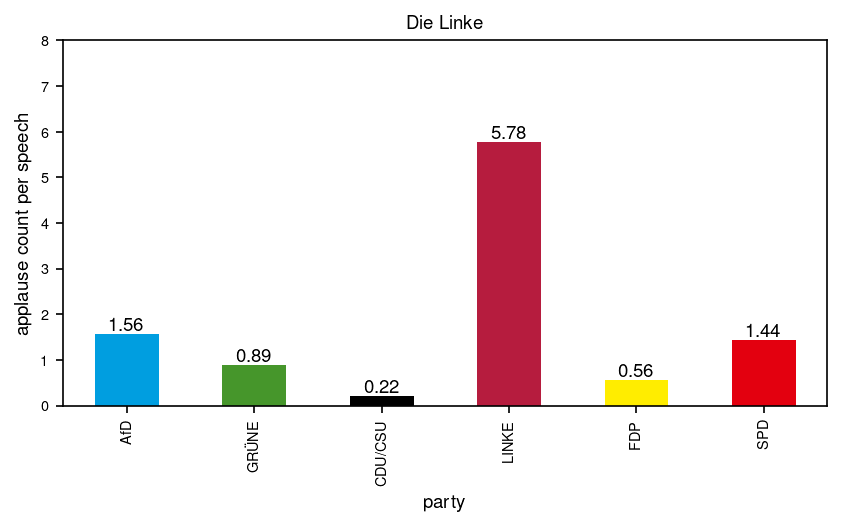

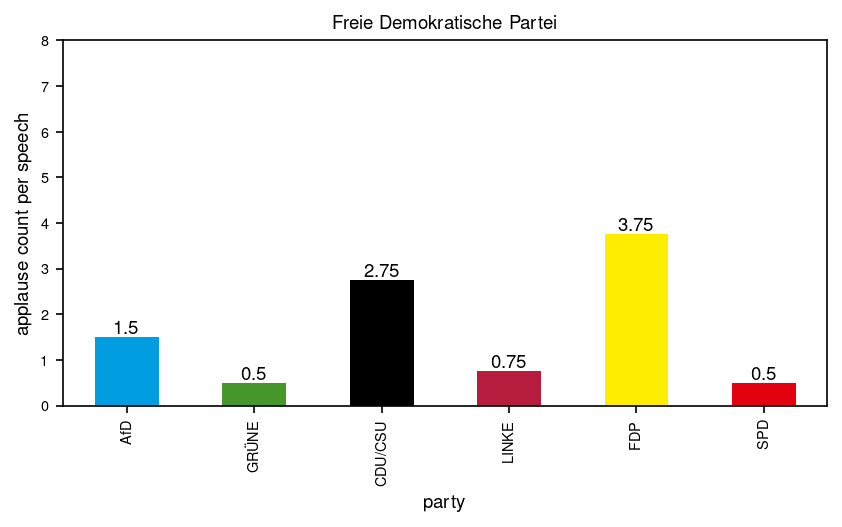

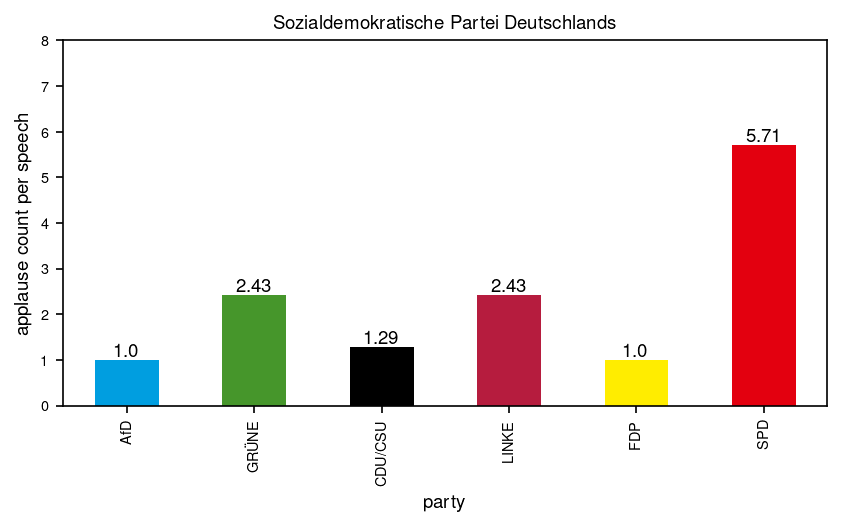

In [6]:
for (party, applauseDF) in applauseDFs:
    applauseDF["normalized applause count"] = np.round(
        applauseDF["applause count"] / len(dataExtracted[dataExtracted["main-speaker-party"] == party]), 2)

    # plot
    ax = applauseDF.plot.bar(
        x="party", y="normalized applause count", ylabel="applause count per speech", legend=False, title=party, ylim=(0, 8), color=sixParties)  # hard coded y-axis!
    for p in ax.patches:
        ax.annotate(p.get_height(),
                    (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 4), textcoords='offset points')


Since CDU/CSU applaude together but have different speakers we want to join both together


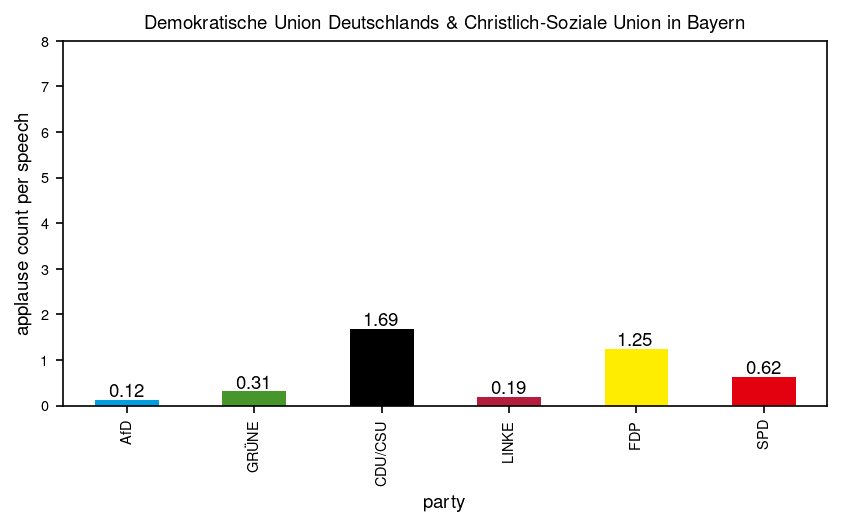

In [7]:
# Combine CDU & CSU DFs
cduDF = applauseDFs[2][1]
csuDF = applauseDFs[3][1]
combindedDF = cduDF.set_index("party").add(
    csuDF.set_index("party"), fill_value=0).reset_index()

combindedDF["normalized applause count"] = np.round(combindedDF["applause count"] / (len(
    dataExtracted[dataExtracted["main-speaker-party"] == "Christlich Demokratische Union Deutschlands"]) + len(dataExtracted[dataExtracted["main-speaker-party"] == "Christlich-Soziale Union in Bayern"])), 2)


# Replace CDU with CDU&CSU Tuple
applauseDFs[2] = (
    "Christlich Demokratische Union Deutschlands & Christlich-Soziale Union in Bayern", combindedDF)
# Remove old CSU Tuple
applauseDFs.pop(3)
parties = ['Alternative für Deutschland', 'Bündnis 90/Die Grünen', 'Christlich Demokratische Union Deutschlands & Christlich-Soziale Union in Bayern',
           'Die Linke', 'Freie Demokratische Partei', 'Sozialdemokratische Partei Deutschlands']

# plot
ax = combindedDF.plot.bar(
    # watch out! With tueplots special characters like & without \ result in a latex exception
    x="party", y="normalized applause count", ylabel="applause count per speech", legend=False, title="Demokratische Union Deutschlands \& Christlich-Soziale Union in Bayern", ylim=(0, 8), color=sixParties)  # hard coded y-axis!
for p in ax.patches:
    ax.annotate(p.get_height(),
                (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')


As a nice side-product we can also plot the Speech count per Party


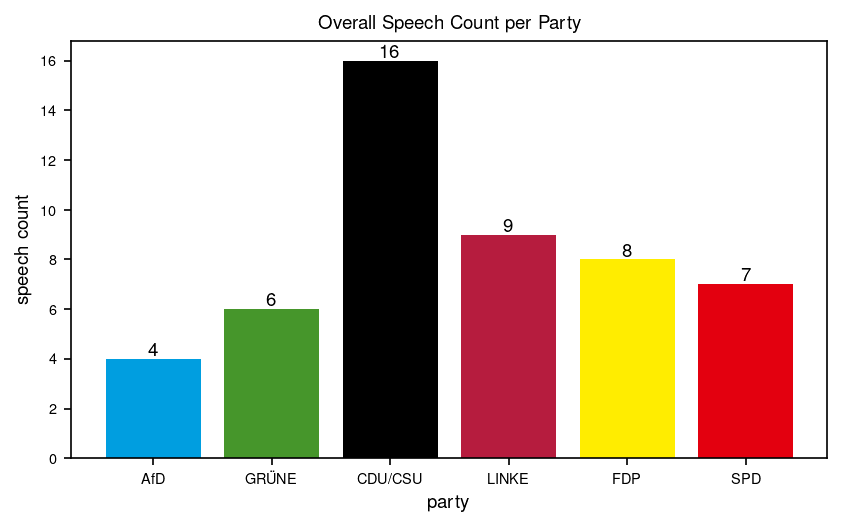

In [8]:
shortNames = ["AfD", "GRÜNE", "CDU/CSU", "LINKE", "FDP", "SPD"]

speechCounts = {}
for (longName, shortName) in zip(parties, shortNames):
    if(shortName == "CDU/CSU"):
        speechCounts[shortName] = len(dataExtracted[dataExtracted["main-speaker-party"] == "Christlich Demokratische Union Deutschlands"]
                                      ) + len(dataExtracted[dataExtracted["main-speaker-party"] == "Christlich-Soziale Union in Bayern"])
    else:
        speechCounts[shortName] = len(
            dataExtracted[dataExtracted["main-speaker-party"] == longName])

fig, ax = plt.subplots()

cntPlot = plt.bar(*zip(*speechCounts.items()), color=sixParties)
plt.title("Overall Speech Count per Party")
plt.xlabel("party")
plt.ylabel("speech count")
for i, bar in enumerate(cntPlot):
    ax.annotate(bar.get_height(),
                (bar.get_x()+bar.get_width()/2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')


Now have a lot of plots we can read some information out of but it would be really cool to consice all this to a matrix format


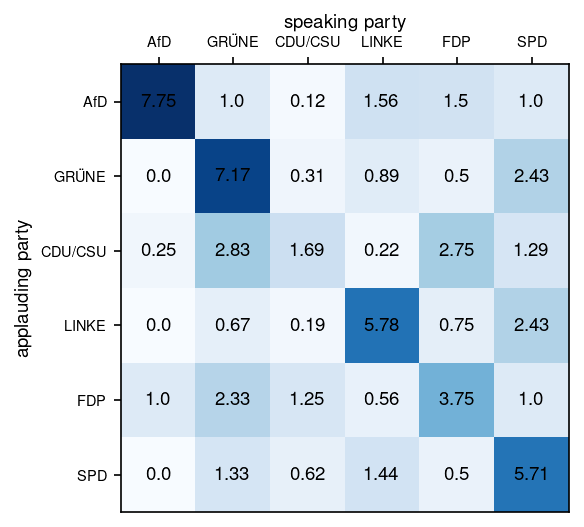

In [9]:
# We want something like this:

# speech party -
# applauding party |

#     A    B
# A  1.0  0.3
# B  0.5  1.0

# We can read this like:
# ->  B applaudes A more often than A B, both parties (on average and per speech) always applaude themselves

applauseCorrelation = pd.Series(
    [party for (party, _) in applauseDFs], name="speaking party")

for (party, applauseDF) in applauseDFs:
    applauseCorrelation = pd.concat([applauseCorrelation, pd.Series(
        applauseDF["normalized applause count"], name=party)], axis=1)

# plot
applauseMatrix = applauseCorrelation.drop("speaking party", axis=1).to_numpy()
axis_values = np.arange(0, len(shortNames), 1)

fig, ax = plt.subplots()
ax.matshow(applauseMatrix, cmap=plt.cm.Blues)
ax.set_xlabel("speaking party")
ax.set_ylabel("applauding party")
ax.xaxis.tick_top() # no ticks at the bottom
ax.xaxis.set_label_position('top') 
ax.set_xticks(axis_values)
ax.set_xticklabels(shortNames)
ax.set_yticks(axis_values)
ax.set_yticklabels(shortNames)
for i in range(6):
    for j in range(6):
        c = applauseMatrix[j, i]
        ax.text(i, j, str(c), va='center', ha='center')
